# Simulación de Montecarlo para Estimar Precios Futuros de Acciones

Bienvenidos a este capítulo que se centra en el uso de las simulaciones de Montecarlo para estimar los precios futuros de una acción. Durante este notebook, exploraremos una técnica poderosa y versátil que se utiliza comúnmente en el mundo de las finanzas para evaluar el riesgo, valorar derivados y el rendimiento de inversiones: la simulación de Montecarlo.

**TEMAS A TRATAR**

En este notebook, abordaremos los siguientes temas clave:

1. **Simulaciones de Montecarlo**

Las simulaciones de Montecarlo son una técnica estadística que se utiliza para modelar el comportamiento de sistemas complejos o inciertos mediante la generación de múltiples escenarios aleatorios. En el contexto financiero, podemos aplicar esta técnica para simular los retornos futuros de una acción, lo que nos permitirá estimar su precio futuro.

2. **Retornos Logarítmicos y Distribución Normal**

Una de las premisas fundamentales de las simulaciones de Montecarlo en finanzas es que los retornos logarítmicos de una acción siguen una distribución normal. Esto significa que, en promedio, los retornos futuros tienden a seguir una tendencia central, y la mayoría de las observaciones se agrupan alrededor de esa media. Esto nos proporciona un punto de partida para nuestras simulaciones.

3. **Independencia de Retornos**

Otra suposición clave es que los retornos logarítmicos son independientes entre sí. Esto significa que el rendimiento de un período no está relacionado con el rendimiento de otros períodos. Aunque esta suposición puede no ser completamente precisa en la realidad, es un enfoque simplificado que se utiliza ampliamente en simulaciones de Montecarlo.

4. **Simulación de Retornos Futuros**

Utilizaremos la característica de independencia y la distribución normal de los retornos logarítmicos para simular retornos futuros. Generaremos números aleatorios que sigan una distribución normal con la media y desviación típica de los retornos pasados. Estos números representarán los retornos en diferentes períodos futuros.

5. **Cálculo de Precios Futuros**

Para estimar los precios futuros de la acción, utilizaremos los retornos simulados. Sumaremos los retornos al precio actual y calcularemos la exponencial para obtener los precios futuros. Esto nos proporcionará un rango de posibles trayectorias de precios.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
import mplfinance as mpf
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

plt.style.use('ggplot')

* Bajar los precios de cierre ajustados del SP500 y guárdalo en una variable llamada sp500_df

* Selecciona los datos entre las fechas '2010-01-01' y '2017-12-31' y guárdalo en una variable llamada sp500_per

* Haz una gráfica de los precios de cierre ajustados del SP500 entre las fechas anteriores

In [59]:
sp500_df = yf.download(tickers='^GSPC')[['Adj Close']]

[*********************100%%**********************]  1 of 1 completed


Vamos a simular posibles series a futuro del índice SP500. Elegimos el periodo entre los años 2010 y 2018

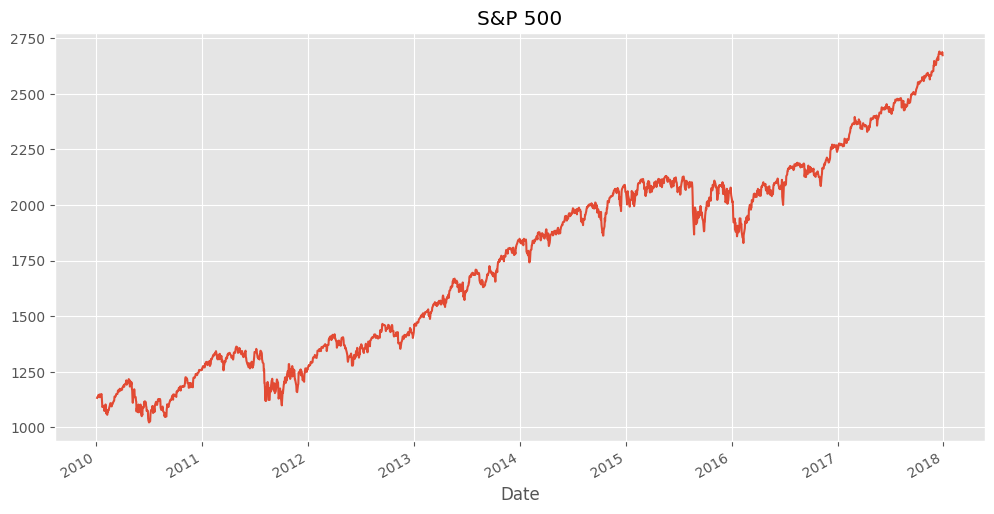

In [60]:

start_date = '2010-01-01'
end_date = '2017-12-31'

sp500_per = sp500_df[start_date:end_date]
sp500_per.plot(figsize=(12,6), legend=False, title='S&P 500');

CALCULAMOS LOS RETORNOS LOGARÍTMICOS, LA MEDIA Y LA DESVIACIÓN TÍPICA Y COMPROBAMOS SI SE AJUSTAN A UNA DISTRIBUCIÓN NORMAL Y SI SON INDEPENDIENTES

* Calcula los retornos logarítmicos del SP500 y guárdalo en una variable llamada ret_sp500_per

* Calcula la media y la desviación típica de los retornos logarítmicos y guárdalos en variables llamadas sp500_media y sp500_std

* Haz una gráfica de los retornos logarítmicos del SP500

In [61]:
ret_sp500_per = np.log(sp500_per).diff().dropna()

#Calculamos la media y la desviación estándar de los rendimientos
sp500_media = ret_sp500_per.mean()
sp500_std = ret_sp500_per.std()

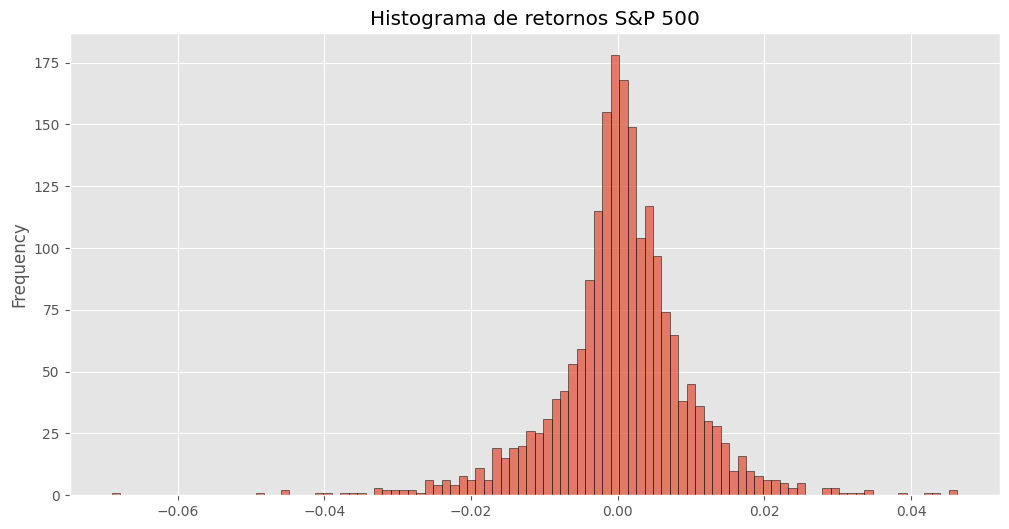

In [62]:
#Vemos si los rendimientos siguen una distribución normal
ret_sp500_per.plot(kind='hist', bins=100, figsize=(12,6), title='Histograma de retornos S&P 500', edgecolor='black', legend=False, alpha=0.7);

GENERAMOS LOS RETORNOS FUTUROS USANDO LA MEDIA Y LA DESVIACIÓN TÍPICA DE LOS RETORNOS PASADOS Y UNA DISTRIBUCIÓN NORMAL

* C alcular cuántos días hay que simular y guardarlo en una variable llamada n_days

* Definir el número de simulaciones y guardarlo en una variable llamada n_sim

* Generar una matriz de números aleatorios con la media y la desviación típica de los retornos logarítmicos y el número de días y simulaciones calculados anteriormente y guárdalo en una variable llamada ret_sim

In [63]:
#Vamos a simular el mismo número de días que tenemos en el histórico
n_days = ret_sp500_per.shape[0]

#Vamos a simular 100 escenarios de rendimientos
n_sim = 100

# Crear un generador de números aleatorios
rng = np.random.default_rng()

# Generar números aleatorios siguiendo una distribución normal
ret_sim = rng.normal(loc=sp500_media, scale=sp500_std, size= (n_days, n_sim))


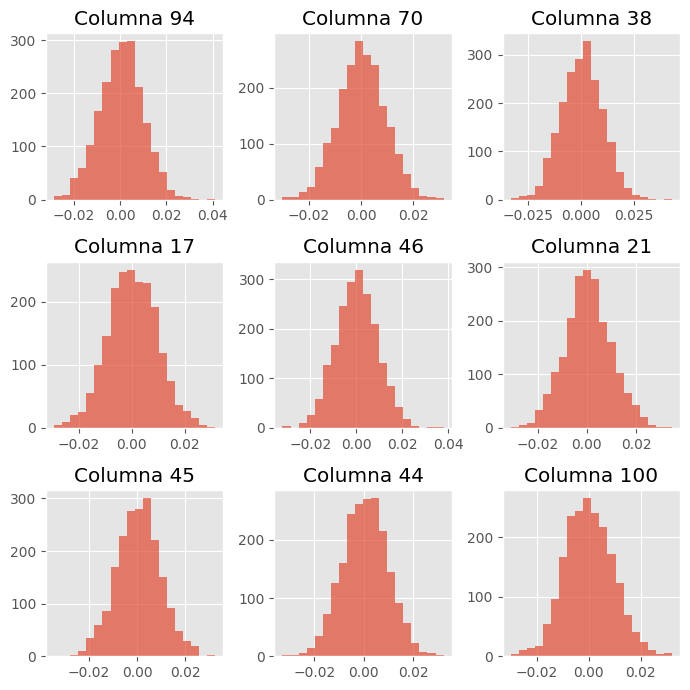

In [64]:
# Seleccionar 9 columnas al azar
col_sel = rng.choice(ret_sim.shape[1], size=9, replace=False)

# Crear histogramas para las 9 columnas seleccionadas
plt.figure(figsize=(7, 7))

for i, col in enumerate(col_sel):
    plt.subplot(3, 3, i + 1)  # Organizar los plots en una cuadrícula de 3x3
    plt.hist(ret_sim[:, col], bins=20, alpha=0.7)
    plt.title(f'Columna {col + 1}')

plt.tight_layout()
plt.show()

VAMOS A CALCULAR LOS PRECIOS A PARTIR DE LOS RETORNOS SIMULADOS

Sabemos que:

* Rendimientos logarítmicos: $r_t = \log(\frac{P_t}{P_{t-1}})$

por lo tanto:

* $P_t = P_{t-1} \exp(r_t)$

donde $P_t$ es el precio en el tiempo $t$ y $r_t$ es el rendimiento logarítmico en el tiempo $t$.

Y generalizando:

$P_t = P_0 \exp(r_1 + r_2 + ... + r_t)$

para calcular los precios hemos de:

* Calcular la suma acumulada de los retornos y guardarla en la variable ret_cum_sim

* Multiplicar el precio inicial por la exponencial de la suma de los retornos y guardalo en sp500_sim

* Añadir una fila inicial con el precio inicial, pasarlo a formato DataFrame  y guárdalo en una variable llamada precios_sim_df

In [65]:
#Calculamos los precios simulados
ret_cum_sim = ret_sim.cumsum(axis=0)
sp500_sim = sp500_per.values[0][0] * np.exp(ret_cum_sim)

Añadimos una fila inicial con el mismo valor que la primera fila de la serie de precios para poder calcular los precios futuros

In [66]:
#Generamos la fila inicial con el precio inicial
fila_0 = np.ones((1, n_sim))*sp500_per.values[0][0]

#Concatenamos la fila inicial con los precios simulados
precios_sim = np.concatenate((fila_0, sp500_sim), axis=0)

#Convertimos los precios simulados en un DataFrame de Pandas
precios_sim_df = pd.DataFrame(precios_sim, index=sp500_per.index, columns=range(n_sim))

HACEMOS UNA GRÁFICA CON LOS PRECIOS SIMULADOS Y LOS PRECIOS REALES

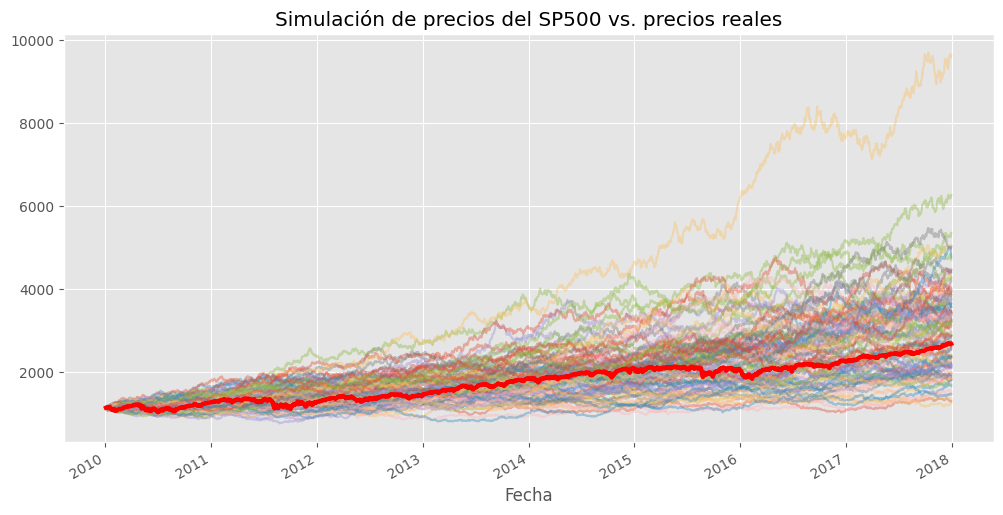

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))
precios_sim_df.plot(legend=False, alpha=0.4, ax=ax) #Graficamos los precios simulados
sp500_per.plot(ax=ax, color='red', linewidth=3, legend=False) #Graficamos los precios reales
plt.title('Simulación de precios del SP500 vs. precios reales')
plt.xlabel('Fecha')
plt.show()

EN VEZ DE GRAFICAR TODAS LAS SERIES, GRAFICAMOS LA MEDIA, MEDIANA Y LOS PERCENTILES 5 Y 95 DE LAS SERIES SIMULADAS

* Calculamos los quantiles 0.05 y 0.95 de los precios simulados y guardalos en variable llamada precios_quantile_evol

* Hacemos una gráfica que muestre:
    
    1-  La serie de precios reales

    2-  La media de los precios simulados

    3-  La mediana de los precios simulados
 
    4-  Los percentiles 5 y 95 de los precios simulados

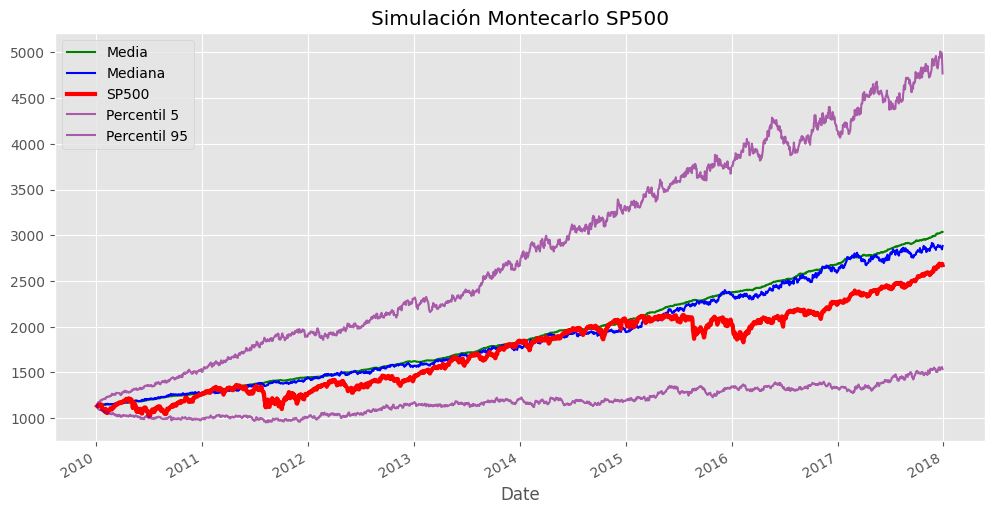

In [68]:
#Calculamos los percentiles 5 y 95 de los precios simulados
precios_quantile_evol = precios_sim_df.quantile(q=[0.05,0.95],axis=1).T

#Hacemos la gráfica
fig, ax = plt.subplots(figsize=(12,6))
precios_sim_df.mean(axis=1).plot(ax=ax, color='green');
precios_sim_df.median(axis=1).plot(ax=ax, color='blue');
sp500_per.plot(ax=ax, color='red', linewidth=3)
precios_quantile_evol.plot(ax=ax, color='purple',  alpha=0.6)
plt.legend(['Media', 'Mediana', 'SP500', 'Percentil 5', 'Percentil 95'])
plt.title('Simulación Montecarlo SP500')
plt.show()

HEMOS UTILIZADO LOS DATOS HISTÓRICOS PARA SIMULAR ESOS MISMOS DATOS HISTÓRICOS. ¿QUÉ PASARÍA SI UTILIZAMOS LOS DATOS HISTÓRICOS PARA SIMULAR DATOS FUTUROS?

* Selecciona los precios a partir del 31 de diciembre de 2017 y guádalos en un dataframe llamado sp500_resto

* Calcula los retornos logarítmicos de sp500_resto y guárdalos en un dataframe llamado ret_sp500_resto

* Haz una gráfica de los precios y de los retornos logarítmicos

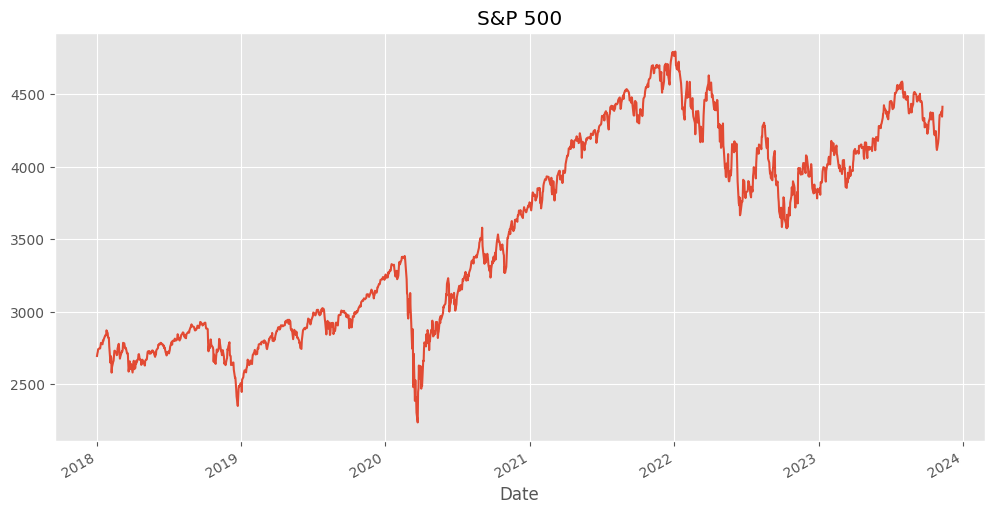

In [69]:
#Nos quedasmos con los precios reales a partir del 31 de diciembre de 2017
sp500_resto = sp500_df['2017-12-31':]
#Calculamos los rendimientos
ret_sp500_resto = np.log(sp500_resto).diff().dropna()
#Hacemos una gráfica de los precios futuros
sp500_resto.plot(figsize=(12,6), legend=False, title='S&P 500');

Mirad la diferencia entre los precios que usamos para generar los retornos y los precios futuros que vamos a simular

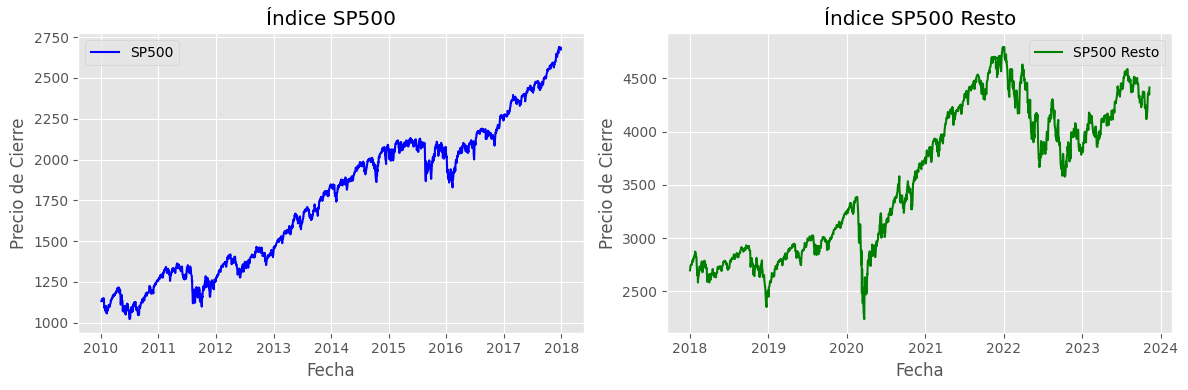

In [70]:
# Crear una figura con dos subplots (1 fila y 2 columnas)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Graficar los datos de sp500 en el primer subplot
ax[0].plot(sp500_per.index, sp500_per, label='SP500', color='blue')
ax[0].set_title('Índice SP500')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('Precio de Cierre')
ax[0].legend()

# Graficar los datos de sp500_resto en el segundo subplot
ax[1].plot(sp500_resto.index, sp500_resto, label='SP500 Resto', color='green')
ax[1].set_title('Índice SP500 Resto')
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('Precio de Cierre')
ax[1].legend()

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

* Calcula el número de días que hay entre el 31 de diciembre de 2017 y el final de la serie de precios

* Genera 100 series de retornos logarítmicos simulados con la media y la desviación típica de los retornos logarítmicos de sp500

* Añade una fila inicila con los los precios del primer día de la serie de precios y guárdalo en una variable llamada precios_sim_df



In [75]:
#simulamos los mismos días que tenemos en el futuro
n_days = ret_sp500_resto.shape[0]
#simulamos 100 escenarios de rendimientos
n_sim = 1000
#Generamos los rendimientos simulados
ret_sim = rng.normal(loc=sp500_media, scale=sp500_std, size= (n_days, n_sim))
#Calculamos los precios simulados
ret_cum_sim = ret_sim.cumsum(axis=0)
sp500_sim = sp500_resto.values[0][0] * np.exp(ret_cum_sim)

In [76]:
#Generamos la fila inicial con el precio inicial
fila_0 = np.ones((1, n_sim))*sp500_resto.values[0][0]
#Concatenamos la fila inicial con los precios simulados
precios_sim = np.concatenate((fila_0, sp500_sim), axis=0)
#Convertimos los precios simulados en un DataFrame de Pandas
precios_sim_df = pd.DataFrame(precios_sim, index=sp500_resto.index, columns=range(n_sim))

HACEMOS UNA GRÁFICA CON LOS PRECIOS SIMULADOS Y LOS PRECIOS REALES

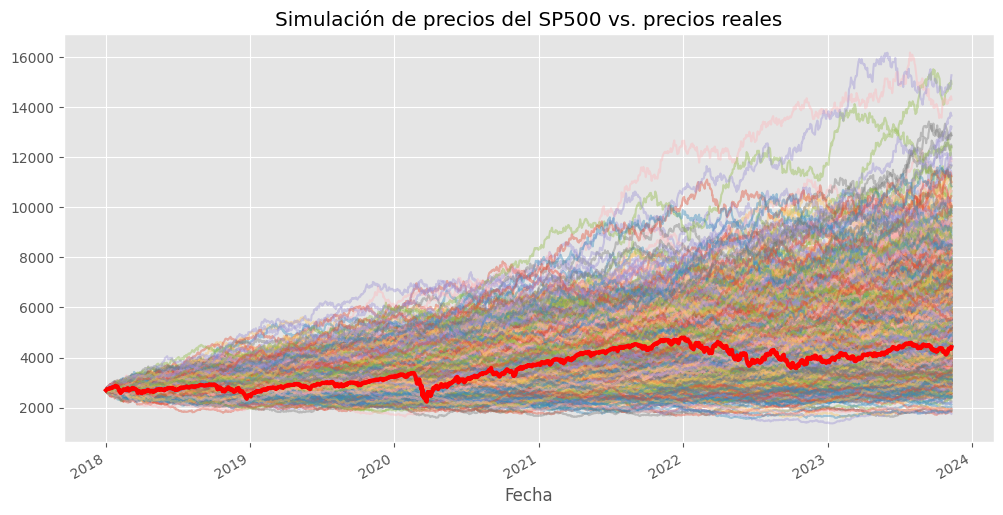

In [77]:
fig, ax = plt.subplots(figsize=(12, 6))
precios_sim_df.plot(legend=False, alpha=0.4, ax=ax)
sp500_resto.plot(ax=ax, color='red', linewidth=3, legend=False)
plt.title('Simulación de precios del SP500 vs. precios reales')
plt.xlabel('Fecha')
plt.show()

EN VEZ DE GRAFICAR TODAS LAS SERIES, GRAFICAMOS LA MEDIA, MEDIANA Y LOS PERCENTILES 5 Y 95 DE LAS SERIES SIMULADAS

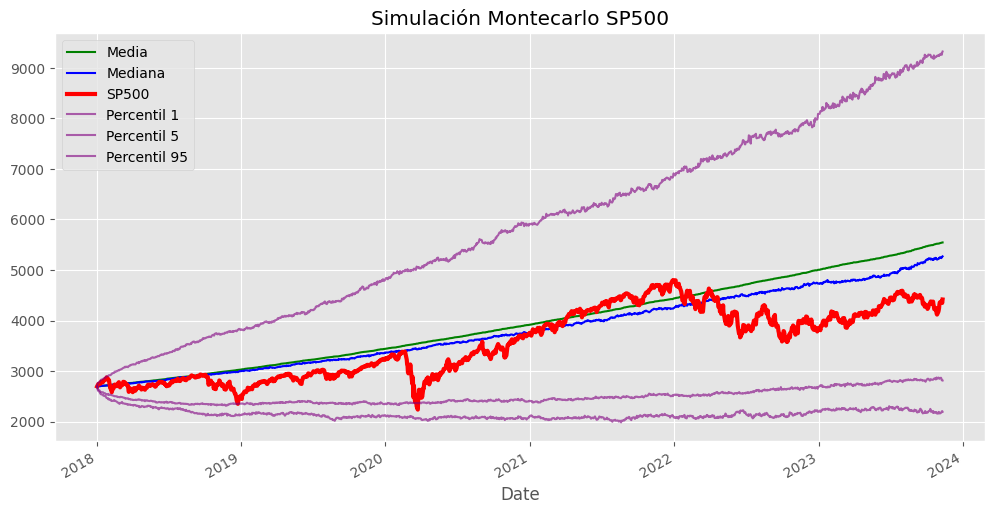

In [78]:
fig, ax = plt.subplots(figsize=(12,6))
precios_sim_df.mean(axis=1).plot(ax=ax, color='green');
precios_sim_df.median(axis=1).plot(ax=ax, color='blue');
sp500_resto.plot(ax=ax, color='red', linewidth=3)
precios_quantile_evol = precios_sim_df.quantile(q=[0.01, 0.05,0.95],axis=1).T
precios_quantile_evol.plot(ax=ax, color='purple',  alpha=0.6)
plt.legend(['Media', 'Mediana', 'SP500', 'Percentil 1', 'Percentil 5', 'Percentil 95'])
plt.title('Simulación Montecarlo SP500')
plt.show()

¿QUÉ PUEDES COMENTAR DE LOS RESULTADOS?

#### ¿QUÉ PASARÍA SI, ELIGIENDO DE MANERA ALEATORIA LOS RETORNOS PASADOS, SIMULAMOS LOS PRECIOS FUTUROS?

In [79]:
# Crear un generador de números aleatorios
rng = np.random.default_rng()

n_sim = 1000

# Seleccionar al azar elementos de la columna 'Adj Close' con reemplazo
ret_choice = rng.choice(ret_sp500_per['Adj Close'], size=(n_days, n_sim), replace=True)

In [80]:
#Calculamos los precios simulados
ret_cum_choice = ret_choice.cumsum(axis=0)
sp500_choice = sp500_resto.values[0][0] * np.exp(ret_cum_choice)

In [81]:
#Generamos la fila inicial con el precio inicial
fila_0 = np.ones((1, n_sim))*sp500_resto.values[0][0]
#Concatenamos la fila inicial con los precios simulados
precios_choice = np.concatenate((fila_0, sp500_choice), axis=0)
#Convertimos los precios choiceulados en un DataFrame de Pandas
precios_choice_df = pd.DataFrame(precios_choice, index=sp500_resto.index, columns=range(n_sim))

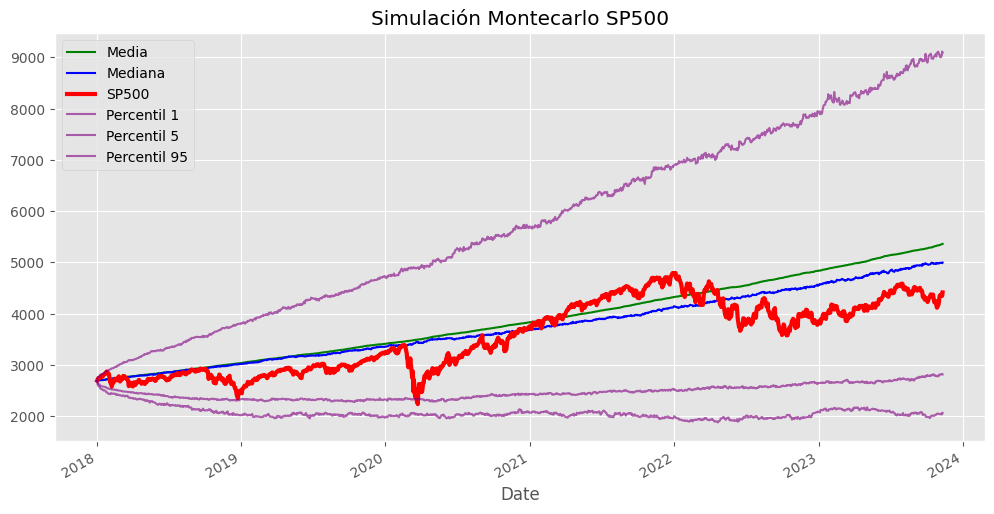

In [82]:
fig, ax = plt.subplots(figsize=(12,6))
precios_choice_df.mean(axis=1).plot(ax=ax, color='green');
precios_choice_df.median(axis=1).plot(ax=ax, color='blue');
sp500_resto.plot(ax=ax, color='red', linewidth=3)
precios_quantile_evol = precios_choice_df.quantile(q=[0.01, 0.05,0.95],axis=1).T
precios_quantile_evol.plot(ax=ax, color='purple',  alpha=0.6)
plt.legend(['Media', 'Mediana', 'SP500', 'Percentil 1', 'Percentil 5', 'Percentil 95'])
plt.title('Simulación Montecarlo SP500')
plt.show()